In [1]:
import utlt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

from scipy import stats
from scipy import fftpack
from scipy.signal import find_peaks, hilbert, windows, blackman, stft
from scipy.integrate import simps
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.linalg import lstsq
from scipy.optimize import curve_fit, nnls, leastsq, minimize, least_squares

from itertools import product
import copy
from split_op_gpe1D import SplitOpGPE1D, imag_time_gpe1D    # class for the split operator propagation
from numba import njit

from collections import Counter
from dataclasses import dataclass

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm


from sklearn import linear_model

import glob
import os

from datetime import datetime

threads = 16
os.environ["OMP_NUM_THREADS"] = '{}'.format(threads)
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

In [2]:
"""
Define default params and use the default utility for saving
"""
k = 1
x_win = np.pi/k
x_lim = 36 * np.pi
x_res = 2 ** 10
dx = 2. * x_lim / x_res

# Number of pulses
n = 3
# Determine the error tolerance
eps = 1e-4
k_max = 0.25 * k
named_params = {
    'tgt_freq': k,
    'pulses': n,
    'max_freq': k_max,
    'x_window': round(x_win, 2),
    'x_bounds': round(x_lim, 2),
    'eps': eps,
}
params = copy.deepcopy(named_params)
file_path, file_name= utlt.build_saves_tag(params_list=named_params, unique_identifier='SCF_Fitting', parent_directory='Archive_Data/Superoscilations')
ok = utlt.standardize_plots(plt.rcParams)


Parent directory check passed! 
Results will be available in Archive_Data/Superoscilations

You may be overwriting previous data (; n;)



In [3]:
def Phi(time, frequency, phase=0, amplitude=1):
    return amplitude * np.sin(frequency * time + phase)

def Phi_transform(time, frequency, amplitude_1, amplitude_2):
    return amplitude_1 * np.sin(frequency * time) + amplitude_2 * np.cos(frequency * time)

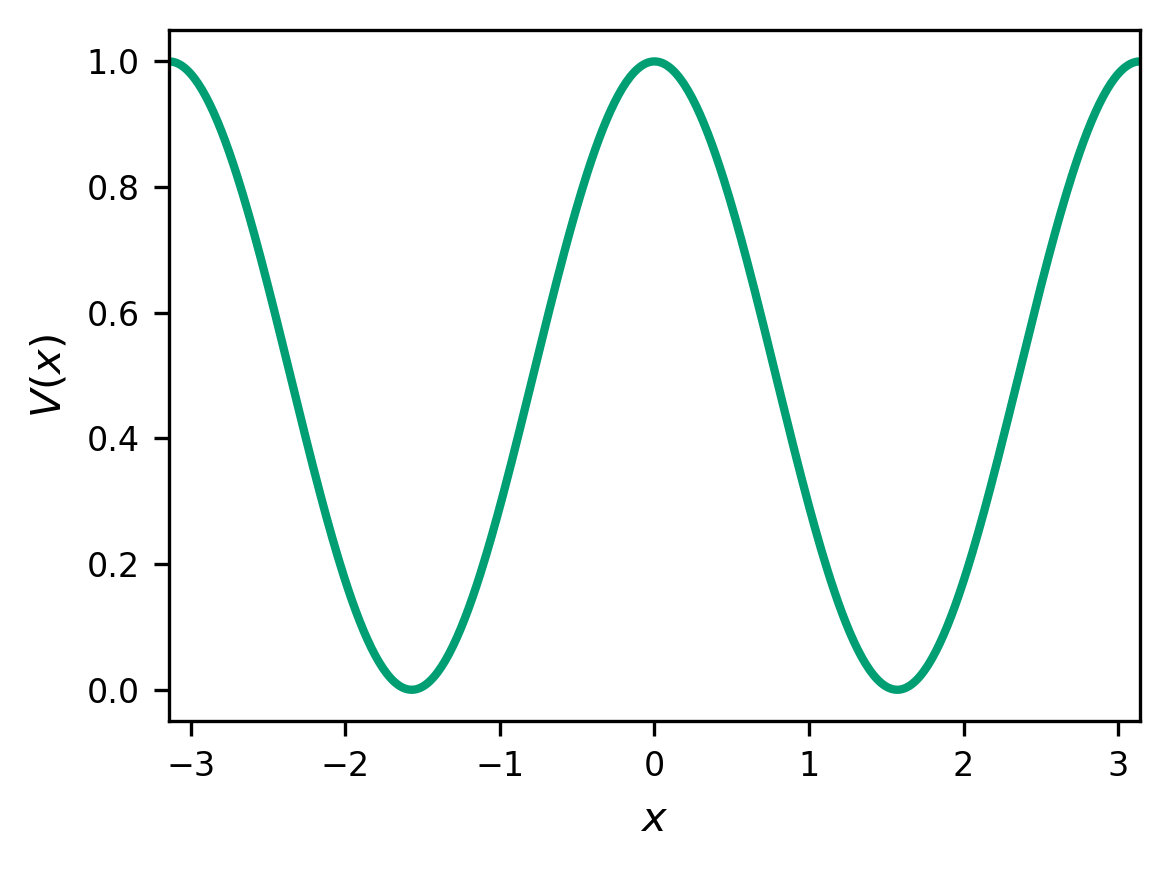

In [4]:
k = 1
x = np.linspace(-x_win, x_win, 500)
zoom_out_x = (np.arange(x_res) - x_res / 2) * dx
target_barrier = Phi(k, x, phase=np.pi/2) #* (x < 0.75/k) * (x > -0.75/k)
plt.plot(x, np.abs(target_barrier) ** 2, color=ok['green'])
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(x[0], x[-1])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Initial_Trap.png')
#plt.savefig('./Plots/Presentation/Initial_Trap.png')
plt.show()

In [5]:
##############################################
#
# Get the initial guesses for the optimization
#
##############################################

# New array for time
# Set
workers = 64
# Number of initial guesses per thread
init_guess_n = workers * 10


seed = np.random.default_rng(2024)
# Create the array of variables for the initial guess
initial_guess = np.hstack([
    # Phase
    seed.uniform(-2*np.pi, 2*np.pi, (init_guess_n, n)),
    # Amplitudes
    seed.uniform(1, 20, (init_guess_n, n))
])

freqs = np.linspace((k_max / n), k_max, n)

print('Number of Pulses: {}'.format(n))
#initial_guess = np.array([20, 0, 0, 1])

print('Length of x: ' + str(len(initial_guess)))

print(f'Frequencies are: {freqs}')

# Define the constraints
phase_lims = (-2 * np.pi, 2 * np.pi)           # Time delay constrained to be positive
ampl_lims = (None, None)      # No constraints for amplitude


# Create the array of bounds for the best fit minimization
bnds = np.concatenate([
    # Phase limits
    np.full((n, 2), phase_lims),
    # Amplitude limits
    np.full((n, 2), ampl_lims)
])

initial_guess_alt = np.hstack([
    # Phase
    seed.uniform(1, 20, (init_guess_n, n)),
    # Amplitudes
    seed.uniform(1, 20, (init_guess_n, n))
])

# Define the constraints
ai_lims = (0, None)
bi_lims = (0, None)


# Create the array of bounds for the best fit minimization
bnds_alt = np.concatenate([
    # Phase limits
    np.full((n, 2), ai_lims),
    # Amplitude limits
    np.full((n, 2), bi_lims)
])

Number of Pulses: 3
Length of x: 640
Frequencies are: [0.08333333 0.16666667 0.25      ]


In [6]:
#######################################
#
# Define Functions for fitting
#
#######################################


def unpack(f):
    # Ensure that the array is equally divisible by number of parameters
    length, res = divmod(len(f), 2)
    assert res == 0
    phases = f[:length]
    amplitudes = f[length:(2 * length)]
    
    return phases, amplitudes

def phi_func(f, t):
    phase, amplitude = unpack(f)
    # Smart way of doing it keeps failing, so do it the very dumb way
    return sum(Phi(t, i, j, k) for i, j, k in zip(freqs, phase, amplitude))

def obj(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func(z, x) - target_barrier) ** 2, 
        f,
        bounds=bnds,
        tol=eps
    )
    return result.fun, result.x



def phi_func_alt(f, t):
    ai, bi = unpack(f)
    # Smart way of doing it keeps failing, so do it the very dumb way
    return sum(Phi_transform(t, i, j, k) for i, j, k in zip(freqs, ai, bi))

def obj_alt(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func_alt(z, x) - target_barrier) ** 2, 
        f,
        bounds=bnds_alt,
        tol=eps
    )
    return result.fun, result.x



In [7]:
def super_obj(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func(z, x)) ** 2, 
        f,
        bounds=bnds,
        tol=eps
    )
    return result.fun, result.x

In [8]:
#########################################################################
#
# Fitting the fields by optimizing the frequencies, delays, and streches
# Uses Parallel computing to find best results
#
#########################################################################

if __name__ == '__main__':
    with Pool(processes=workers) as pool:
        result = pool.map(obj, initial_guess)
        result_super = pool.map(super_obj, initial_guess)
        result_alt = pool.map(obj_alt, initial_guess_alt)

[-3.8050664  -1.25746136 -4.57575025  9.34274381 23.28546078 17.3396534 ]


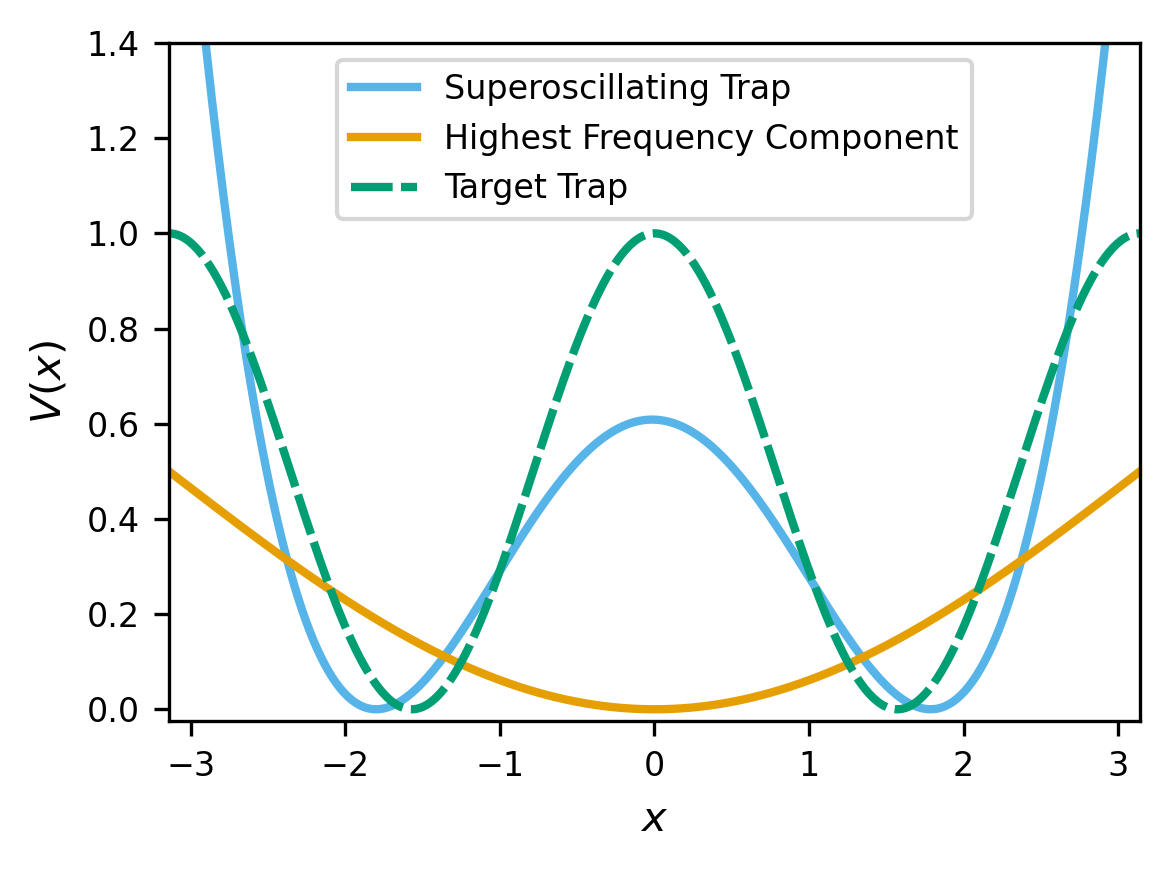

In [9]:
############################################################
#
# Get the best result for minimization of objective function
#
############################################################

result.sort(key=lambda _: _[0])
opt_vals = result[0][1]
best_fit = phi_func(opt_vals, x)
print(opt_vals)

plt.plot(x, np.abs(best_fit) ** 2, label='Superoscillating Trap')
plt.plot(x, np.abs(Phi(x, k_max)) ** 2, label='Highest Frequency Component')
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(x[0], x[-1])
plt.ylim(-0.025, 1.4)
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results.png')
#plt.savefig('./Plots/Presentation/Results.pdf')
plt.show()

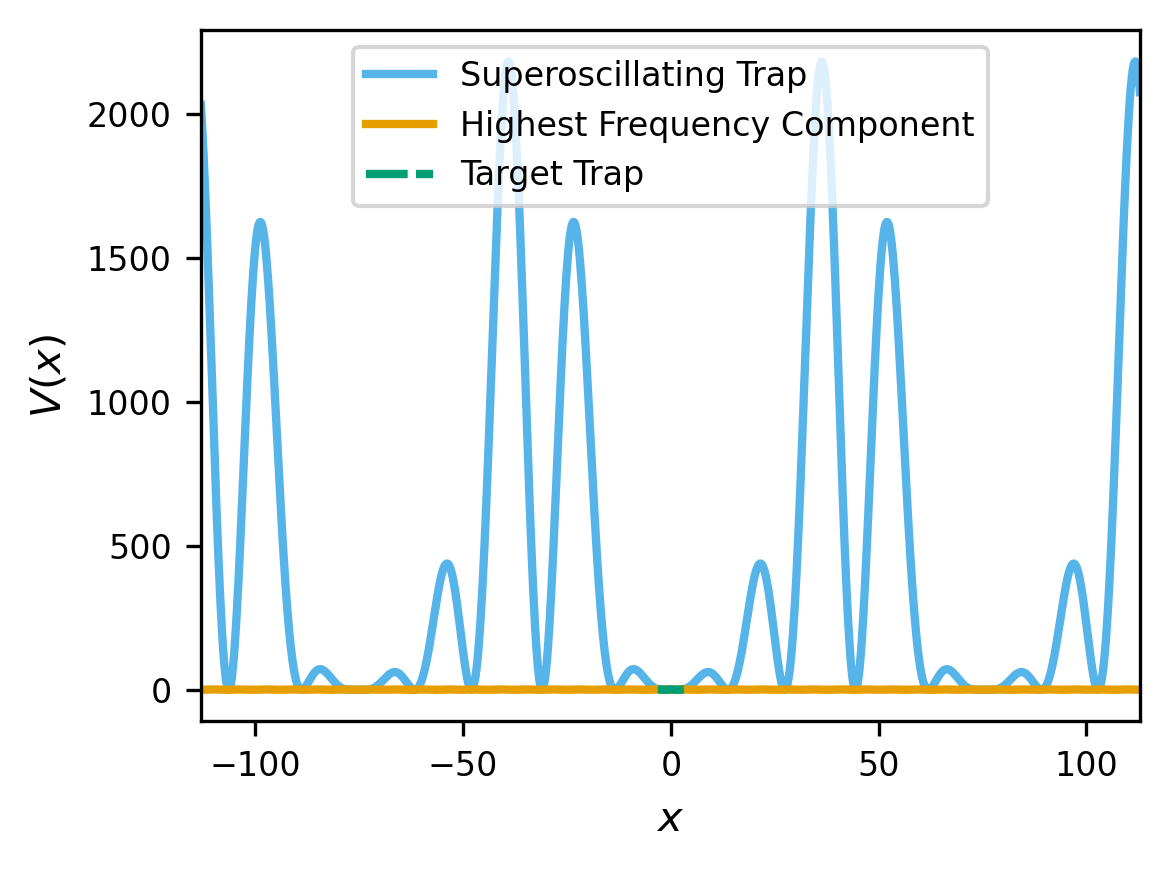

In [10]:
############################################################
#
# Get the best result for minimization of objective function
#
############################################################

best_fit_zoom = phi_func(opt_vals, zoom_out_x)

plt.plot(zoom_out_x, best_fit_zoom ** 2, label='Superoscillating Trap')
plt.plot(zoom_out_x, Phi(zoom_out_x, k/2) ** 2, label='Highest Frequency Component')
plt.plot(x, target_barrier ** 2, linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(zoom_out_x[0], zoom_out_x[-1])
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ResultsZoomed.png')
#plt.savefig('./Plots/Presentation/ResultsZoomed.pdf')
plt.show()

[0.         0.         0.         0.         0.         0.07152936]


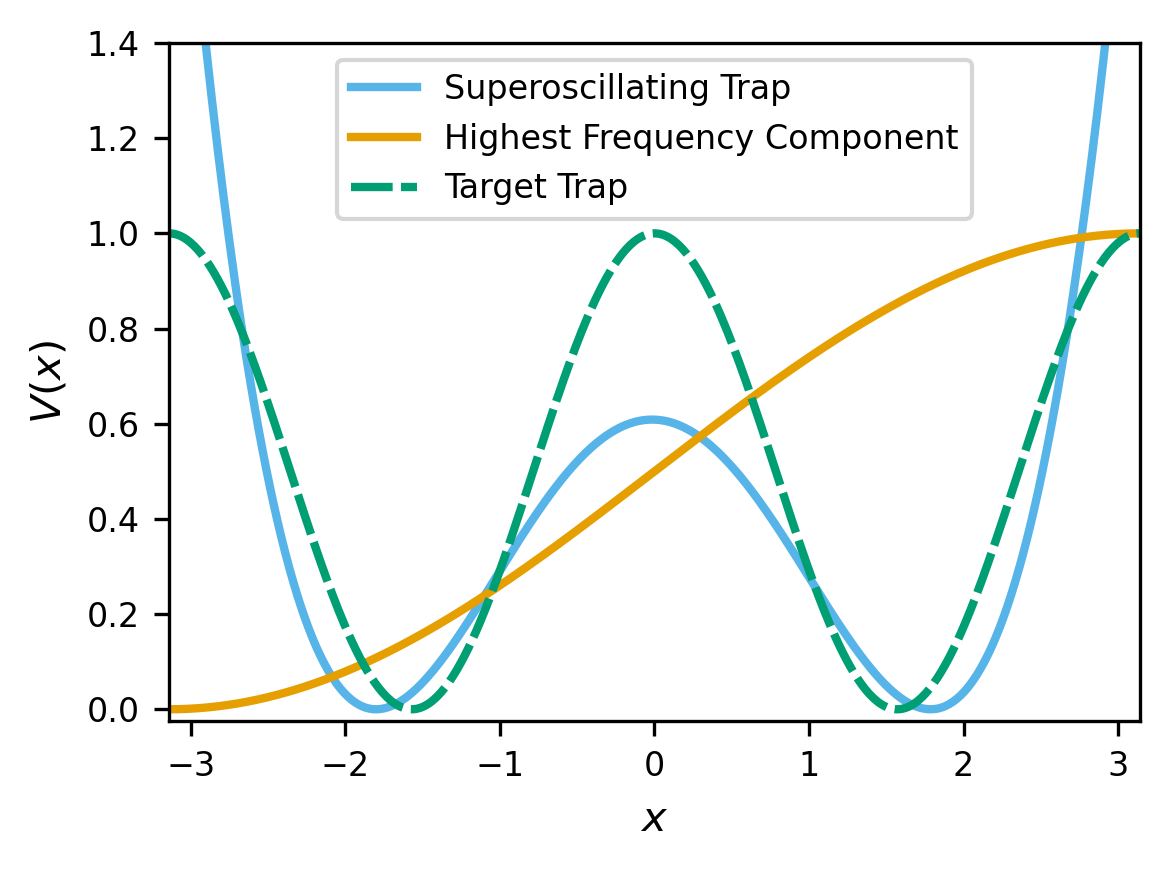

In [11]:
############################################################################
#
# Get the best result for minimization of the alternative objective function
#
############################################################################

result_alt.sort(key=lambda _: _[0])
opt_vals_alt = result_alt[0][1]
best_fit_alt = phi_func(opt_vals, x)
print(opt_vals_alt)

plt.plot(x, np.abs(best_fit_alt) ** 2, label='Superoscillating Trap')
plt.plot(x, np.abs(Phi_transform(x, k_max, 1/np.sqrt(2), 1/np.sqrt(2))) ** 2, label='Highest Frequency Component')
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(x[0], x[-1])
plt.ylim(-0.025, 1.4)
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_alt.png')
#plt.savefig('./Plots/Presentation/Results_alt.pdf')
plt.show()

In [12]:
#########################################################################
#
# Fitting the fields by linear model, as it can be convexly solved
#
#########################################################################
fields = np.array([
    Phi(x, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T

fields_zoomed = np.array([
    Phi(zoom_out_x, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T

#model = linear_model.Lasso(alpha=0.0001, fit_intercept=False, tol=1e-6, max_iter=100000)
#model = linear_model.Ridge(fit_intercept=False, tol=1e-6, max_iter=100000)
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(fields, target_barrier)

linear_optimized_fields = fields @ model.coef_
lo_fields_zoom = fields_zoomed @ model.coef_

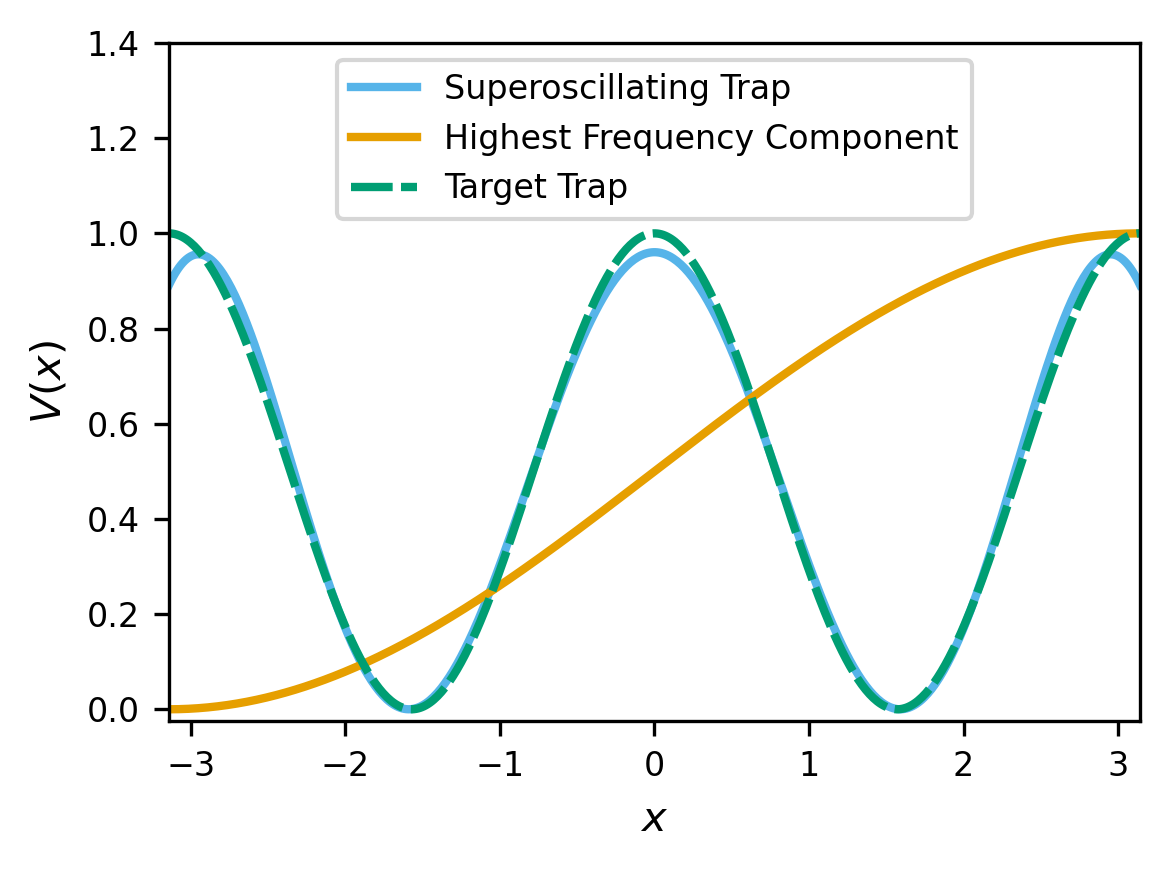

In [13]:
############################################################################
#
# Plot the results for linear optimization
#
############################################################################


plt.plot(x, np.abs(linear_optimized_fields) ** 2, label='Superoscillating Trap')
plt.plot(x, np.abs(Phi_transform(x, k_max, 1/np.sqrt(2), 1/np.sqrt(2))) ** 2, label='Highest Frequency Component')
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(x[0], x[-1])
plt.ylim(-0.025, 1.4)
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_linear.png')
# plt.savefig('./Plots/Presentation/Results_linear.pdf')
plt.show()

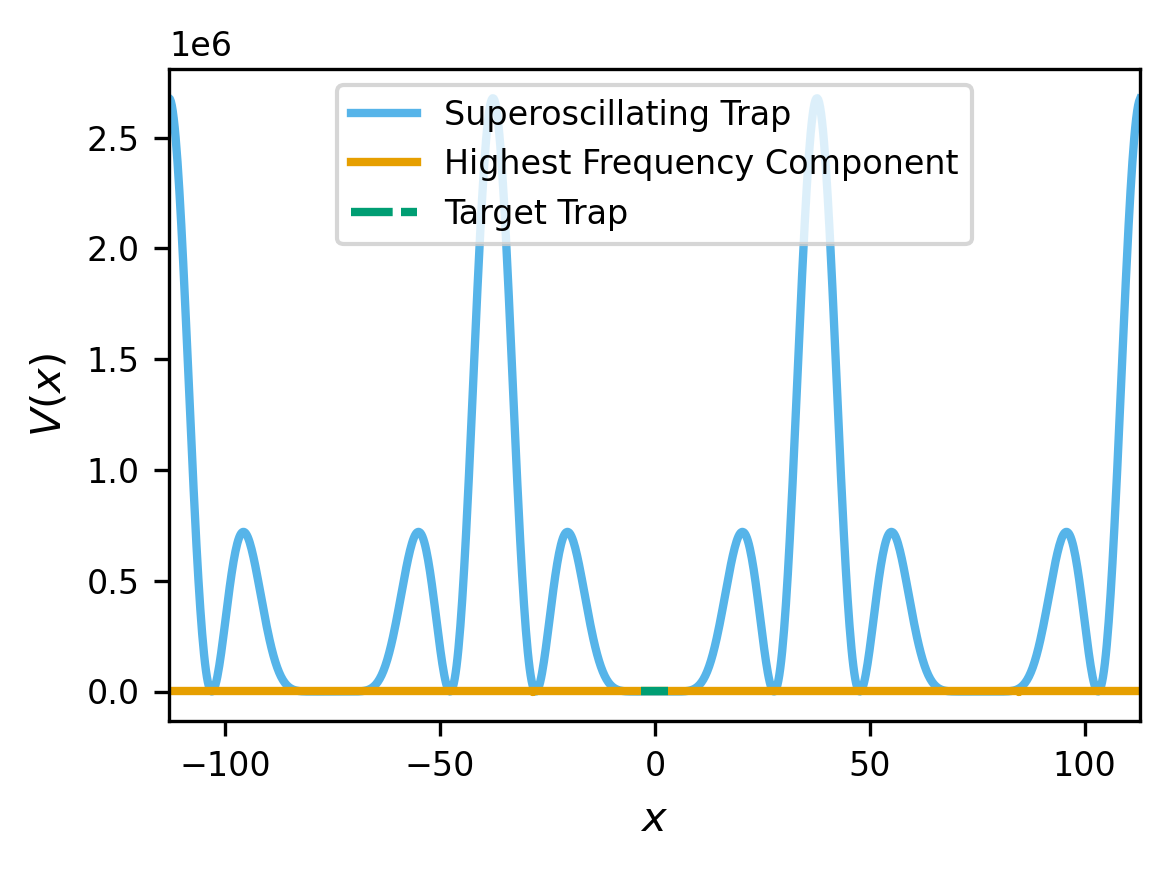

In [34]:
############################################################################
#
# Plot the zoom out of the results for linear optimization
#
############################################################################


plt.plot(zoom_out_x, np.abs(lo_fields_zoom) ** 2, label='Superoscillating Trap')
plt.plot(zoom_out_x, np.abs(Phi_transform(zoom_out_x, k_max, 1/np.sqrt(2), 1/np.sqrt(2))) ** 2, label='Highest Frequency Component')
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(zoom_out_x[0], zoom_out_x[-1])
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_linearZoomed.png')
#plt.savefig('./Plots/Presentation/Results_linearZoomed.pdf')
plt.show()

In [15]:
def get_local_freq(field, time):
    phase = np.unwrap(np.angle(hilbert(field)))
    return np.gradient(phase, np.pi / (time.max() - time.min()))


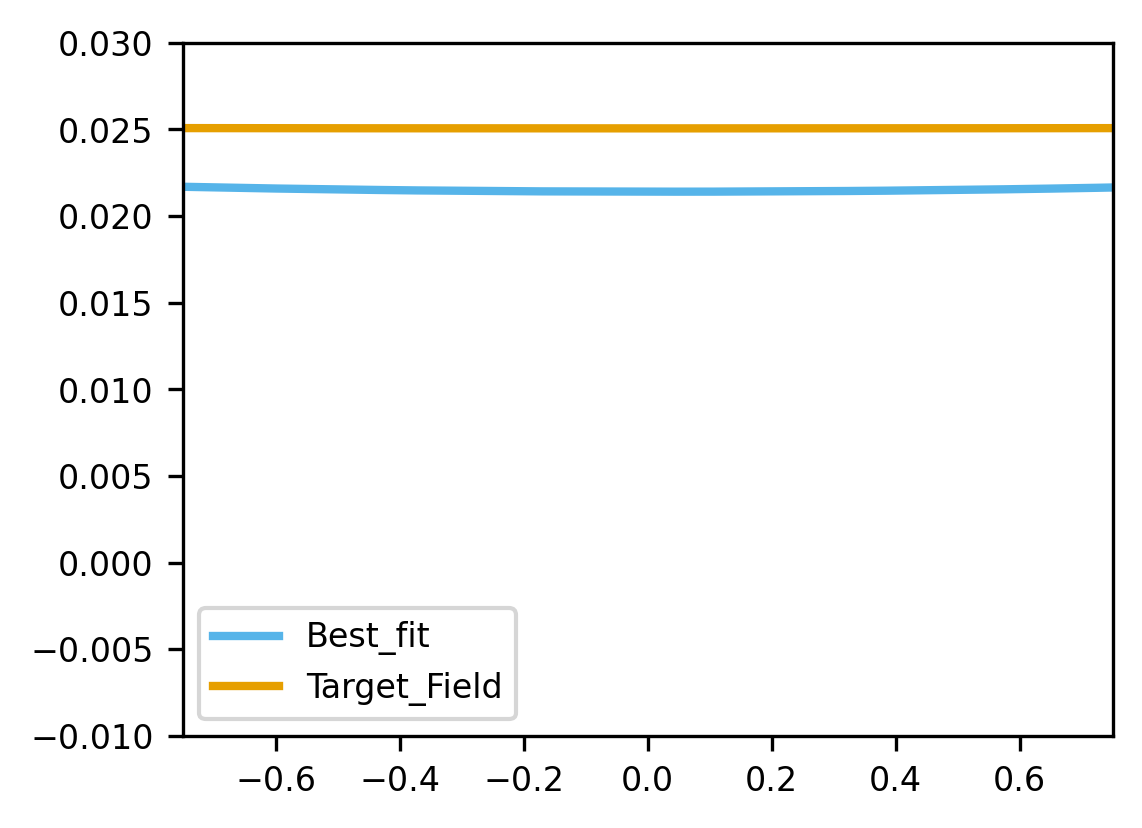

In [16]:
trim_edges=1
cut= slice(trim_edges,-trim_edges)
best_fit_lf = get_local_freq(best_fit[cut], x[cut])
target_lf = get_local_freq(target_barrier[cut], x[cut])
plt.plot(x[cut], best_fit_lf, label='Best_fit')
plt.plot(x[cut], target_lf, label='Target_Field')
plt.xlim(-0.75/k, 0.75/k)
plt.ylim(-0.01, 0.03)
plt.legend()
plt.show()

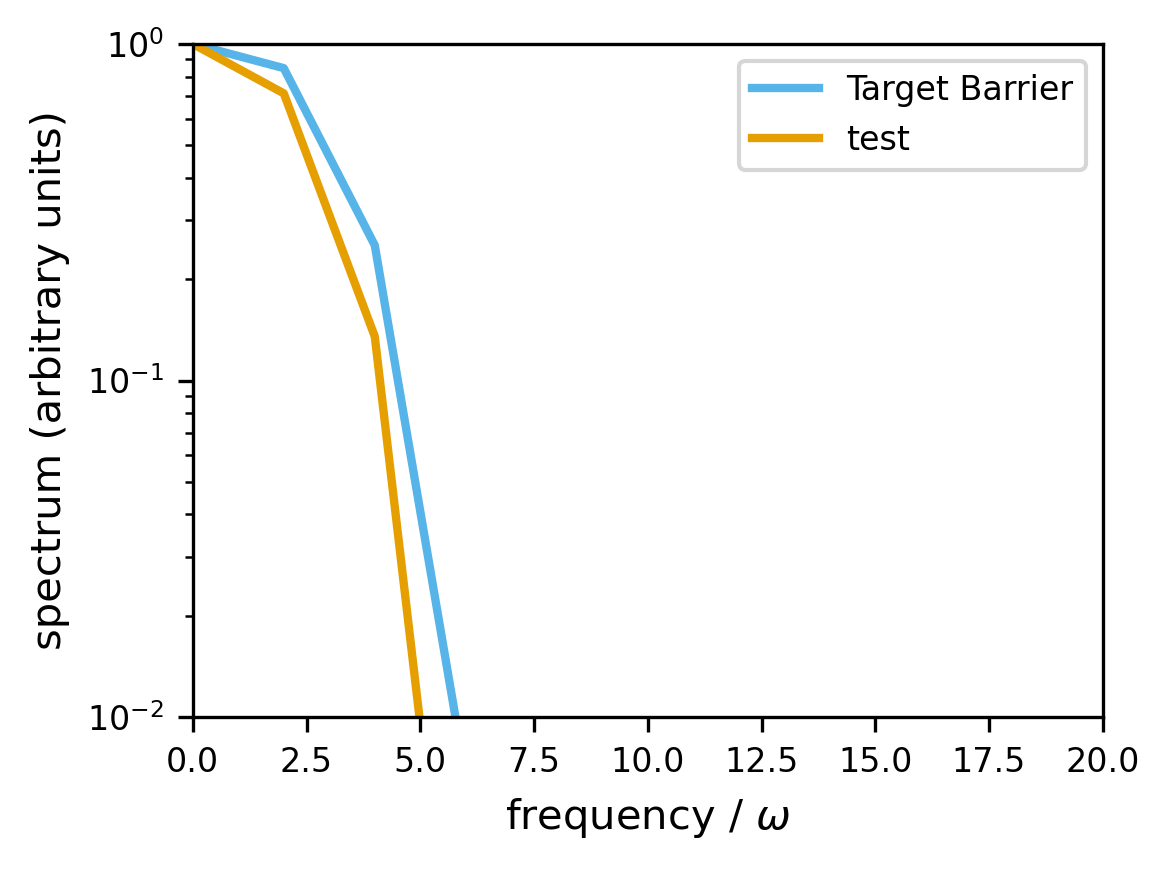

In [17]:
def plot_spectrum(f, t, **kwargs):
    """
    Plot the High Harmonic Generation spectrum
    """
    # Power spectrum emitted is calculated using the Larmor formula
    #   (https://en.wikipedia.org/wiki/Larmor_formula)
    # which says that the power emitted is proportional to the square of the acceleration
    # i.e., the RHS of the second Ehrenfest theorem

    N = len(f)
    K = np.arange(N)

    # frequency range
    omegas = (K - N / 2) * np.pi / (0.5 * t.max())

    # spectra of the
    spectrum = np.abs(
        # used windows fourier transform to calculate the spectra
        # rhttp://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html
        fftpack.fft((-1) ** K * blackman(N) * f)
    ) ** 2
    spectrum /= spectrum.max()
    plt.semilogy(omegas / k, spectrum, **kwargs, label=get)
    plt.ylabel('spectrum (arbitrary units)')
    plt.xlabel(r'frequency / $\omega$')
    plt.xlim([0, 20])
    plt.ylim([1e-2, 1.])

plt.figure()
get = 'Target Barrier'
plot_spectrum(target_barrier, x)
get = 'test'
plot_spectrum(best_fit, x)


plt.legend()
plt.tight_layout()
plt.show()

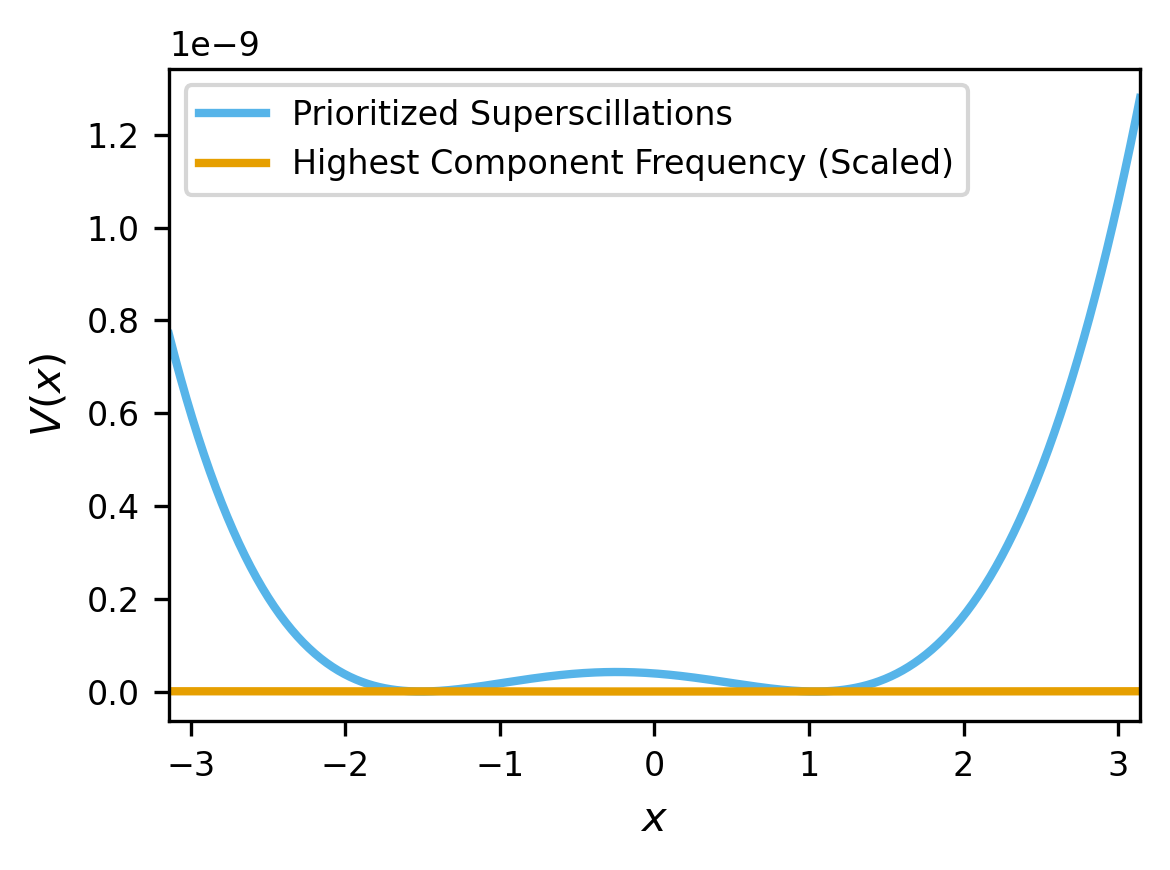

In [18]:
############################################################
#
# Get the best result for minimization of objective function
#
############################################################

result_super.sort(key=lambda _: _[0])
opt_vals = result_super[0][1]
best_fit_super = phi_func(opt_vals, x)

plt.plot(x, (best_fit_super) ** 2, label='Prioritized Superscillations')
plt.plot(x, (Phi(x, k_max)*1e-6) ** 2, label='Highest Component Frequency (Scaled)')
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(x[0], x[-1])
plt.legend()
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Superoscillations.png')
#plt.savefig('./Plots/Presentation/Superoscillations.pdf')
plt.show()

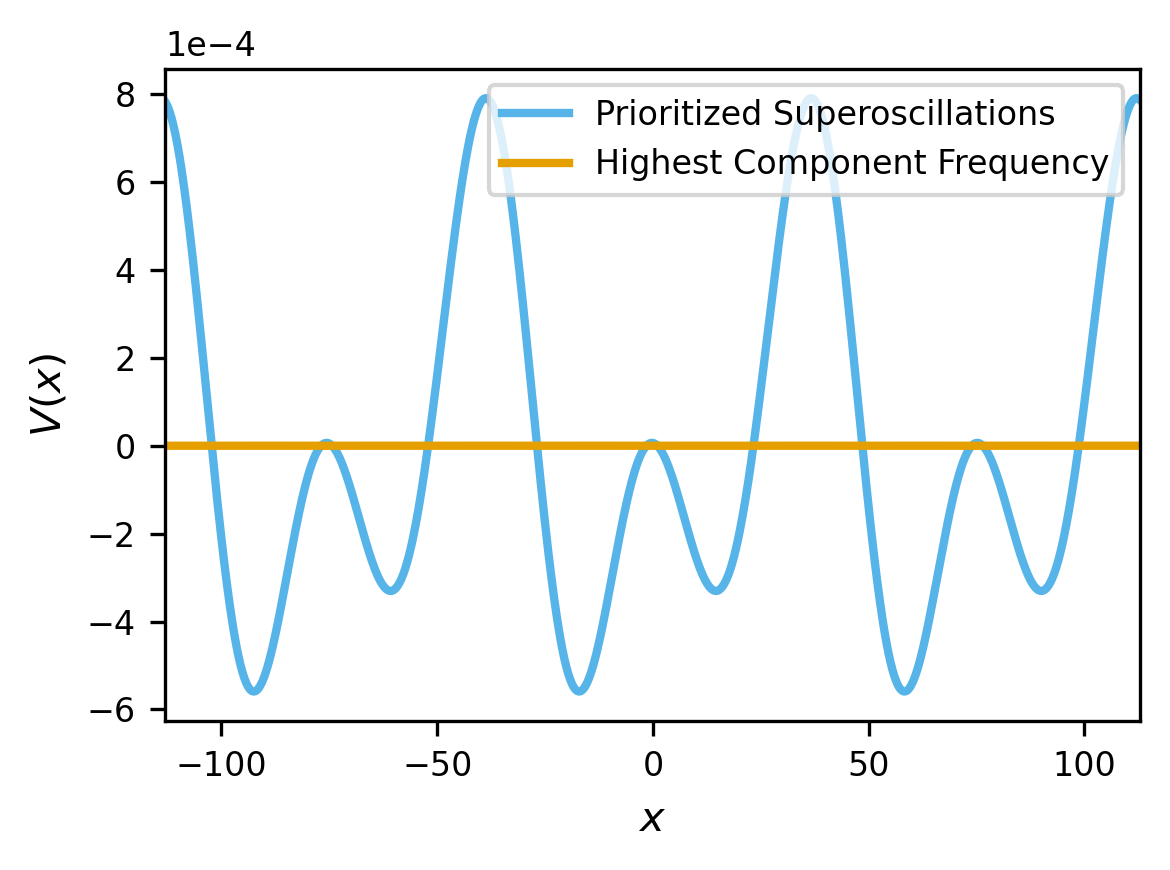

In [19]:
plt.plot(zoom_out_x, phi_func(opt_vals, zoom_out_x), label='Prioritized Superoscillations')
plt.plot(zoom_out_x, Phi(zoom_out_x, k_max)*1e-7, label='Highest Component Frequency')
#plt.plot(x, target_barrier, label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(zoom_out_x[0], zoom_out_x[-1])
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1e-4, 1e-4))
plt.legend()
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_SuperoscillationsZoomed.png')
#plt.savefig('./Plots/Presentation/SuperoscillationsZoomed.pdf')
plt.show()

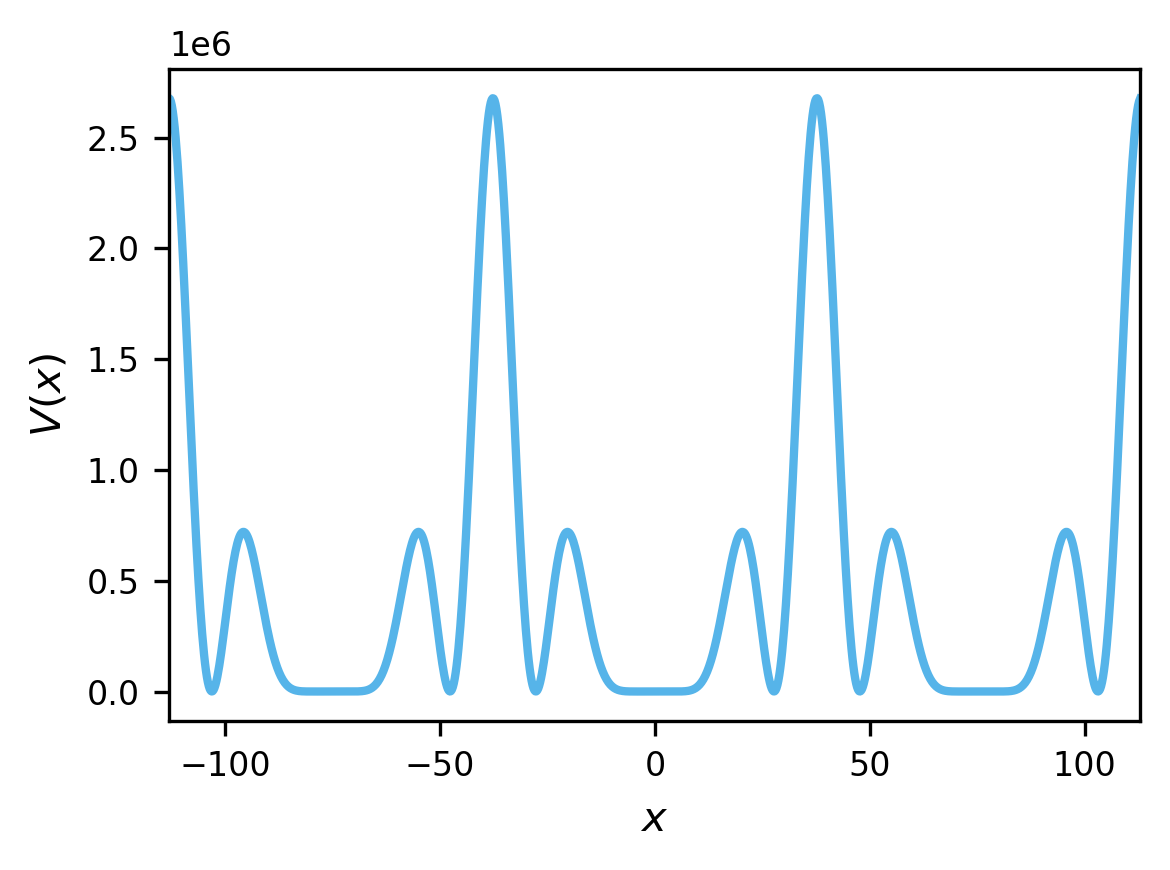

In [42]:
########################################################################################################################
# Get the BEC
########################################################################################################################

atom_params = dict(
    atom='R87',
    kicked=False,
)

gpe = utlt.BEC(**atom_params)
g = gpe.g
N = gpe.N
dz = dx
# generate coordinate range
z = zoom_out_x
T = 3
times = np.linspace(0, T, 500)

@njit
def diff_k(p):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p


@njit(parallel=True)
def k(p):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
    
suggestion_slope=0.01

sys_params = dict(
    x_amplitude=x_lim,
    x_grid_dim=x_res,
    N=N,
    k=k,
    initial_trap=UnivariateSpline(z, (np.abs(lo_fields_zoom) ** 2 + (suggestion_slope * z) ** 2), s=0),
    times=times,
    diff_k=diff_k,
)

plt.plot(z, sys_params['initial_trap'](z))
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(z[0], z[-1])
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-1e-4, 1e-4))
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_CoolingPotential.png')
plt.show()

In [43]:
init_state, mu = imag_time_gpe1D(
    v=sys_params['initial_trap'],
    g=g,
    dt=1e-3,
    epsilon=1e-8,
    **sys_params
)

init_state, mu = imag_time_gpe1D(
    v=sys_params['initial_trap'],
    g=g,
    init_wavefunction=init_state,
    dt=1e-5,
    epsilon=1e-10,
    **sys_params
)


Starting imaginary time propagation
Check for normalized wavefunction=1.0000000000000004
current ground state energy = 2.4631e+01
Check for normalized wavefunction=1.0000000000000004
Check for normalized wavefunction=1.0
Check for normalized wavefunction=1.0
Check for normalized wavefunction=1.0
Check for normalized wavefunction=1.0000000000000002
Check for normalized wavefunction=1.0
Check for normalized wavefunction=0.9999999999999999
Check for normalized wavefunction=1.0
Check for normalized wavefunction=1.0000000000000002
Check for normalized wavefunction=1.0000000000000004
Check for normalized wavefunction=1.0000000000000002
Check for normalized wavefunction=1.0
Check for normalized wavefunction=1.0
Check for normalized wavefunction=1.0000000000000004
Check for normalized wavefunction=0.9999999999999999
Check for normalized wavefunction=0.9999999999999997
Check for normalized wavefunction=0.9999999999999998
Check for normalized wavefunction=1.0000000000000002
Check for normalized

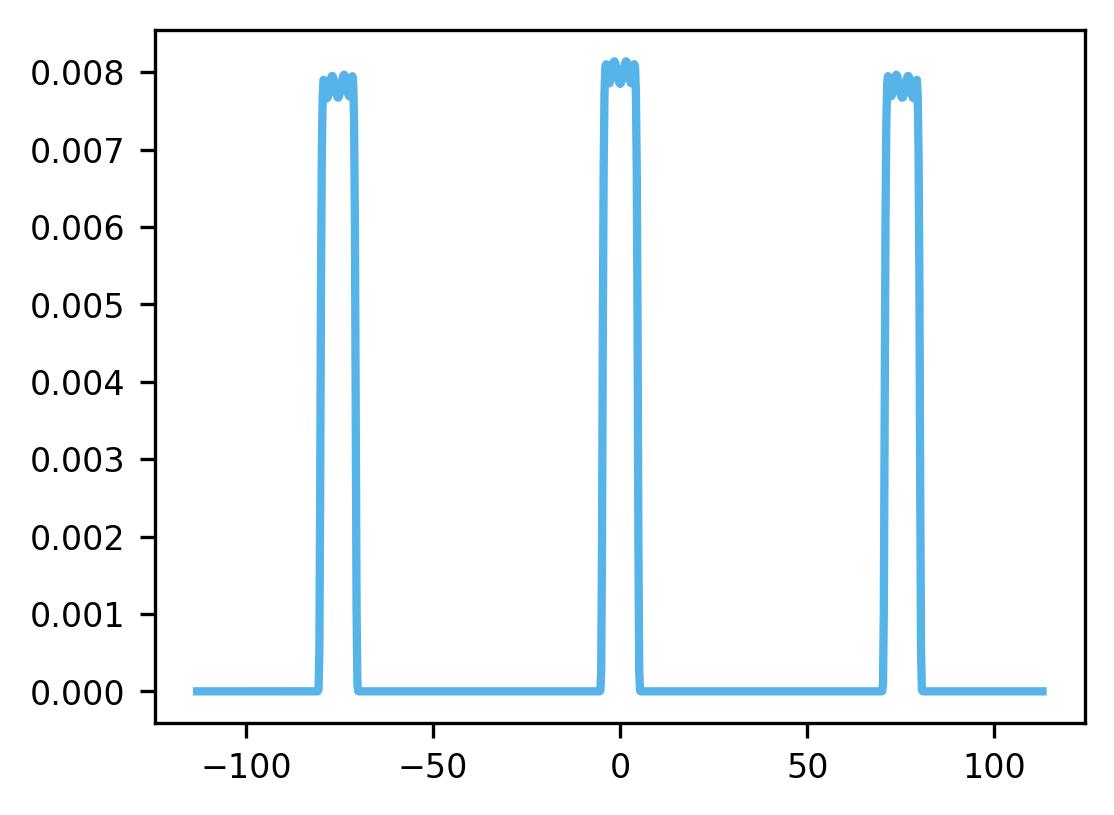

In [44]:
density = np.abs(init_state) ** 2 * dz
plt.plot(z, density)
plt.show()


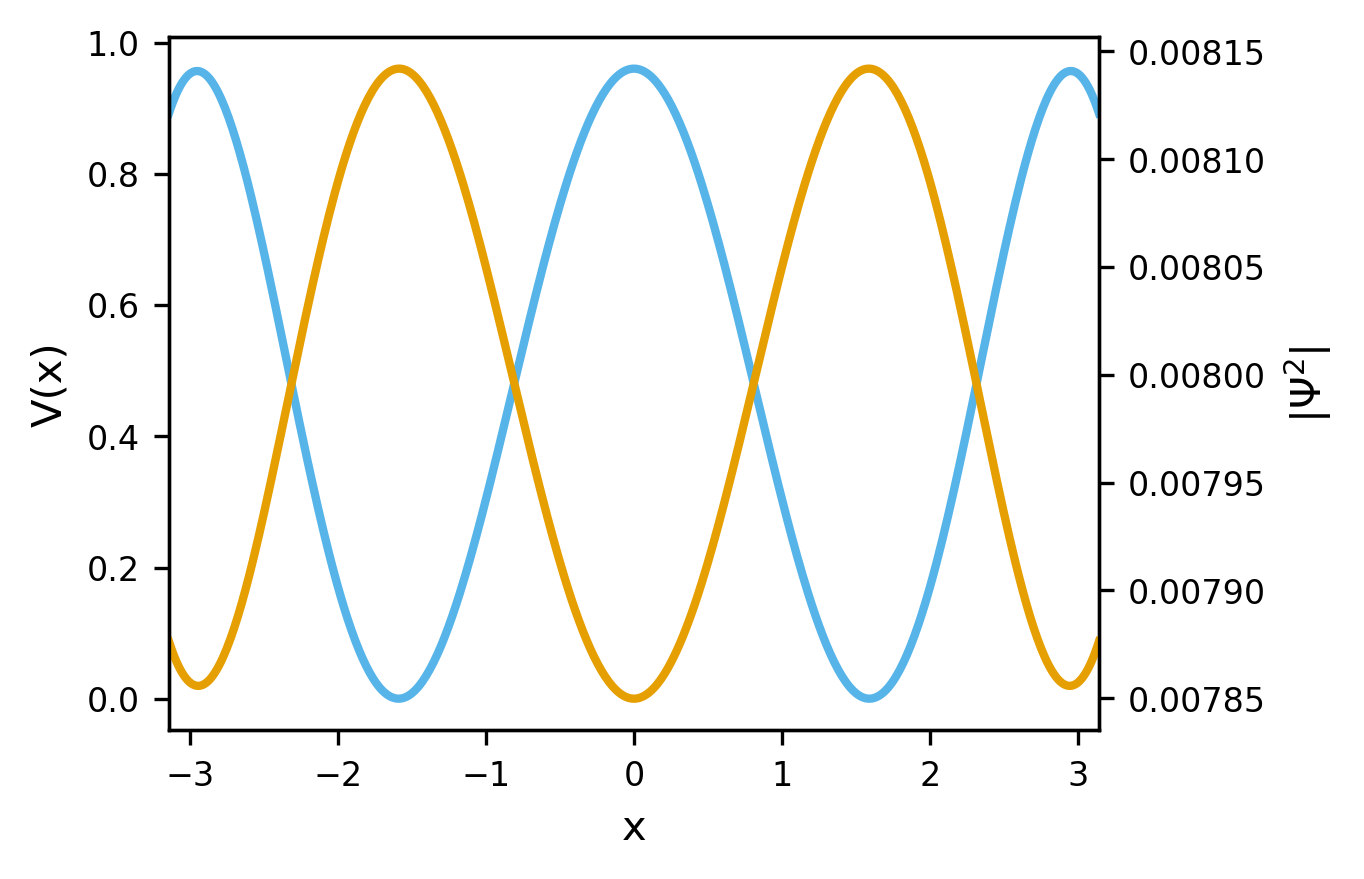

In [45]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(x, sys_params['initial_trap'](x), color=ok['blue'])
ax2=ax1.twinx()
ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_xlabel('x')
ax1.set_xlim(x[0], x[-1])
ax1.set_ylabel('V(x)')
ax2.set_ylabel('|$\\Psi^2$|')
plt.show()